# X-Ray Classification Machine Learning Final Project
- Jack Wagner, Zach Bingaman



In [ ]:
#!pip3 install pydicom

In [35]:
import sklearn
import pydicom
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd

In [38]:
test_files = glob('test/test/test/*/*/*/*')
train_files = glob('train/train/train/*/*/*/*')

In [15]:
len(test_files)

743

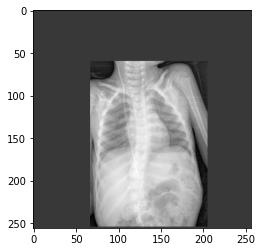

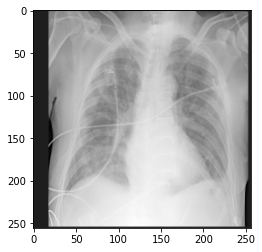

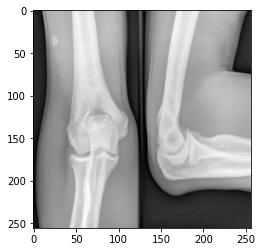

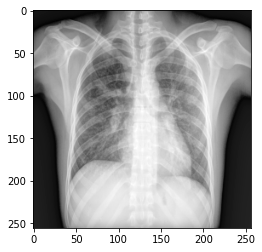

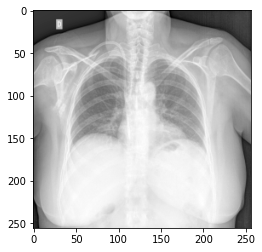

In [16]:
for _file in test_files[:5]:
    plt.figure()
    plt.imshow(pydicom.dcmread(_file).pixel_array, cmap='gray_r')
    plt.show()

In [41]:
pydicom.dcmread(test_files[0]).pixel_array.shape

(256, 256)

In [62]:
data = pd.DataFrame(pydicom.dcmread(test_files[0]).pixel_array.flatten()).T
for file in test_files[1:]:
	data = data.append(pd.DataFrame(pydicom.dcmread(file).pixel_array.flatten()).T)


/var/folders/0v/c3_5nsbs1hx8pz00k835sfy40000gp/T/ipykernel_62876/3691032301.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(pydicom.dcmread(file).pixel_array.flatten()).T)
/var/folders/0v/c3_5nsbs1hx8pz00k835sfy40000gp/T/ipykernel_62876/3691032301.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(pydicom.dcmread(file).pixel_array.flatten()).T)
/var/folders/0v/c3_5nsbs1hx8pz00k835sfy40000gp/T/ipykernel_62876/3691032301.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(pydicom.dcmread(file).pixel_array.flatten()).T)
/var/folders/0v/c3_5nsbs1hx8pz00k835sfy40000gp/T/ipykernel_62876/3691032301.py:3: FutureWarning: The frame.ap

In [65]:
data = data.reset_index()
data

,level_0,index,0,1,2,3,4,5,6,7,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,0,0,22399,22399,22399,22399,22399,22399,22399,22399,...,22399,22399,22399,22399,22399,22399,22399,22399,22399,22399
1,1,0,24575,24575,24575,24575,24575,24575,24575,24575,...,24575,24575,24575,24575,24575,24575,24575,24575,24575,24575
2,2,0,23703,23844,23791,24576,24568,24710,24871,25108,...,23402,23311,23531,23633,23603,23532,23476,23450,23414,23178
3,3,0,24215,24216,24218,24220,24223,24227,24232,24237,...,23595,23574,23556,23539,23525,23512,23502,23495,23489,23484
4,4,0,23675,23676,23677,23681,23683,23658,23683,23694,...,23876,23590,23375,22904,23142,23235,23345,23415,23706,23786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,738,0,24209,24243,24382,24340,24279,24171,24280,24188,...,23324,22983,22943,22765,22909,22838,22861,22460,22742,22376
739,739,0,24612,24589,24613,24542,24635,24638,24594,24526,...,24553,24612,24550,24603,24592,24562,24587,24548,24590,24626
740,740,0,24438,24414,24420,24468,24419,24458,24358,24384,...,24580,24576,24564,24591,24586,24560,24576,24566,24566,24640
741,741,0,22466,22467,22586,22614,22635,22606,22588,22642,...,24093,24013,24219,24063,24111,23971,24186,24165,23947,24285
